# API Testing — PETR4.SA LSTM Stock Price Predictor

Notebook para testar todos os endpoints da API de predição de preços da Petrobras (PETR4.SA).

## Endpoints cobertos
| Método | Rota | Descrição |
|--------|------|-----------|
| GET | `/` | Info da API |
| GET | `/health` | Status de saúde |
| POST | `/predict` | Predição com preços manuais |
| POST | `/predict/live` | Predição com dados do Yahoo Finance |
| POST | `/predict/forecast` | Previsão multi-step (N dias) |
| GET | `/monitoring/stats` | Métricas de sistema |
| GET | `/monitoring/model/info` | Metadados do modelo |
| GET | `/metrics` | Métricas Prometheus |

> **Pré-requisito:** API rodando em `http://localhost:8000`  
> Para iniciar: `docker compose up` ou `uvicorn app.main:app --reload`

## 0. Setup

In [1]:
import json
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

BASE_URL = "http://localhost:8000"
SYMBOL   = "PETR4.SA"

def pretty(response: requests.Response) -> None:
    """Print status code + formatted JSON body."""
    print(f"Status: {response.status_code}")
    try:
        print(json.dumps(response.json(), indent=2, ensure_ascii=False))
    except Exception:
        print(response.text[:2000])

print(f"Base URL : {BASE_URL}")
print(f"Symbol   : {SYMBOL}")

Base URL : http://localhost:8000
Symbol   : PETR4.SA


---
## 1. Health Checks

### 1.1 GET `/` — Root info

In [21]:
response = requests.get(f"{BASE_URL}/")
pretty(response)

Status: 200
{
  "service": "PETR4.SA LSTM Stock Price Predictor",
  "version": "1.0.0",
  "status": "running",
  "model": "LSTM — PETR4.SA (Petrobras)",
  "links": {
    "docs": "/docs",
    "redoc": "/redoc",
    "health": "/health",
    "metrics": "/metrics",
    "model_info": "/monitoring/model/info"
  },
  "timestamp": "2026-02-19T04:43:48.364934Z"
}


### 1.2 GET `/health` — API health check

In [22]:
response = requests.get(f"{BASE_URL}/health")
pretty(response)

data = response.json()
assert response.status_code == 200,   "Health endpoint failed"
assert data["status"] == "healthy",   f"API not healthy: {data['status']}"
assert data["model_loaded"] is True,  "Model not loaded"
print("\n✓ API healthy and model loaded")

Status: 200
{
  "status": "healthy",
  "model_loaded": true,
  "timestamp": "2026-02-19T04:43:49.207681Z"
}

✓ API healthy and model loaded


---
## 2. POST `/predict` — Manual prediction

Envia exatamente **60 preços de fechamento** (mais antigo → mais recente).

In [23]:
# Simulated price window: gradual uptrend from 34.00 to 38.00
prices_manual = list(np.linspace(34.00, 38.00, 60).round(2))

payload = {
    "symbol": SYMBOL,
    "prices": prices_manual,
}

response = requests.post(f"{BASE_URL}/predict", json=payload)
pretty(response)

Status: 200
{
  "symbol": "PETR4.SA",
  "predicted_price": 38.0809,
  "predicted_ratio": 1.120026,
  "reference_price": 34.0,
  "last_known_price": 38.0,
  "expected_change_pct": 0.2128,
  "prediction_for_date": "N/A (data não fornecida)",
  "last_data_date": "N/A (data não fornecida)",
  "inference_time_ms": 41.29,
  "timestamp": "2026-02-19T04:43:50.618977Z"
}


In [24]:
result = response.json()

print(f"Symbol           : {result['symbol']}")
print(f"Last known price : R$ {result['last_known_price']:.4f}")
print(f"Predicted price  : R$ {result['predicted_price']:.4f}")
print(f"Expected change  : {result['expected_change_pct']:+.2f}%")
print(f"Inference time   : {result['inference_time_ms']:.2f} ms")

Symbol           : PETR4.SA
Last known price : R$ 38.0000
Predicted price  : R$ 38.0809
Expected change  : +0.21%
Inference time   : 41.29 ms


### 2.1 Edge case — wrong number of prices (expect 422)

In [25]:
bad_payload = {"symbol": SYMBOL, "prices": [35.0] * 30}  # only 30 prices
response_bad = requests.post(f"{BASE_URL}/predict", json=bad_payload)
print(f"Status: {response_bad.status_code}  (expected 422)")
print(json.dumps(response_bad.json(), indent=2, ensure_ascii=False))

Status: 422  (expected 422)
{
  "detail": [
    {
      "type": "too_short",
      "loc": [
        "body",
        "prices"
      ],
      "msg": "List should have at least 60 items after validation, not 30",
      "input": [
        35.0,
        35.0,
        35.0,
        35.0,
        35.0,
        35.0,
        35.0,
        35.0,
        35.0,
        35.0,
        35.0,
        35.0,
        35.0,
        35.0,
        35.0,
        35.0,
        35.0,
        35.0,
        35.0,
        35.0,
        35.0,
        35.0,
        35.0,
        35.0,
        35.0,
        35.0,
        35.0,
        35.0,
        35.0,
        35.0
      ],
      "ctx": {
        "field_type": "List",
        "min_length": 60,
        "actual_length": 30
      }
    }
  ]
}


---
## 3. POST `/predict/live` — Live prediction (Yahoo Finance)

In [26]:
payload_live = {"symbol": SYMBOL}

response_live = requests.post(f"{BASE_URL}/predict/live", json=payload_live)
pretty(response_live)

Status: 200
{
  "symbol": "PETR4.SA",
  "predicted_price": 37.325,
  "predicted_ratio": 1.167134,
  "reference_price": 31.98,
  "last_known_price": 37.19,
  "expected_change_pct": 0.3629,
  "prediction_for_date": "2026-02-19",
  "last_data_date": "2026-02-18",
  "inference_time_ms": 38.32,
  "timestamp": "2026-02-19T04:43:54.046283Z"
}


In [27]:
live = response_live.json()

print(f"Symbol           : {live['symbol']}")
print(f"Last data date   : {live['last_data_date']}")
print(f"Prediction for   : {live['prediction_for_date']}")
print(f"Last known price : R$ {live['last_known_price']:.4f}")
print(f"Predicted price  : R$ {live['predicted_price']:.4f}")
print(f"Expected change  : {live['expected_change_pct']:+.2f}%")
print(f"Inference time   : {live['inference_time_ms']:.2f} ms")

Symbol           : PETR4.SA
Last data date   : 2026-02-18
Prediction for   : 2026-02-19
Last known price : R$ 37.1900
Predicted price  : R$ 37.3250
Expected change  : +0.36%
Inference time   : 38.32 ms


### 3.1 Edge case — invalid symbol (expect 400/500)

In [28]:
response_invalid = requests.post(f"{BASE_URL}/predict/live", json={"symbol": "INVALID_TICKER_XYZ"})
print(f"Status: {response_invalid.status_code}")
print(json.dumps(response_invalid.json(), indent=2, ensure_ascii=False))

Status: 400
{
  "detail": "No market data found for symbol 'INVALID_TICKER_XYZ'."
}


---
## 4. POST `/predict/forecast` — Multi-step forecast

In [29]:
FORECAST_DAYS = 10

payload_forecast = {"symbol": SYMBOL, "days": FORECAST_DAYS}

response_forecast = requests.post(f"{BASE_URL}/predict/forecast", json=payload_forecast)
pretty(response_forecast)

Status: 200
{
  "symbol": "PETR4.SA",
  "base_price": 37.19,
  "base_date": "2026-02-18",
  "forecast_days": 10,
  "forecast": [
    {
      "day": 1,
      "date": "2026-02-19",
      "predicted_price": 37.325,
      "expected_change_pct": 0.3629
    },
    {
      "day": 2,
      "date": "2026-02-20",
      "predicted_price": 37.2978,
      "expected_change_pct": -0.0729
    },
    {
      "day": 3,
      "date": "2026-02-23",
      "predicted_price": 37.2891,
      "expected_change_pct": -0.0232
    },
    {
      "day": 4,
      "date": "2026-02-24",
      "predicted_price": 37.2969,
      "expected_change_pct": 0.0209
    },
    {
      "day": 5,
      "date": "2026-02-25",
      "predicted_price": 37.2962,
      "expected_change_pct": -0.0019
    },
    {
      "day": 6,
      "date": "2026-02-26",
      "predicted_price": 37.3044,
      "expected_change_pct": 0.022
    },
    {
      "day": 7,
      "date": "2026-02-27",
      "predicted_price": 37.3229,
      "expected_change_p

In [30]:
fc = response_forecast.json()

df_fc = pd.DataFrame(fc["forecast"])
df_fc["date"] = pd.to_datetime(df_fc["date"])
df_fc = df_fc.set_index("date")

print(f"Symbol     : {fc['symbol']}")
print(f"Base date  : {fc['base_date']}")
print(f"Base price : R$ {fc['base_price']:.4f}")
print(f"Days ahead : {fc['forecast_days']}")
print()
print(df_fc[["day", "predicted_price", "expected_change_pct"]].to_string())

Symbol     : PETR4.SA
Base date  : 2026-02-18
Base price : R$ 37.1900
Days ahead : 10

            day  predicted_price  expected_change_pct
date                                                 
2026-02-19    1          37.3250               0.3629
2026-02-20    2          37.2978              -0.0729
2026-02-23    3          37.2891              -0.0232
2026-02-24    4          37.2969               0.0209
2026-02-25    5          37.2962              -0.0019
2026-02-26    6          37.3044               0.0220
2026-02-27    7          37.3229               0.0495
2026-03-02    8          37.3059              -0.0457
2026-03-03    9          37.3157               0.0263
2026-03-04   10          37.3323               0.0445


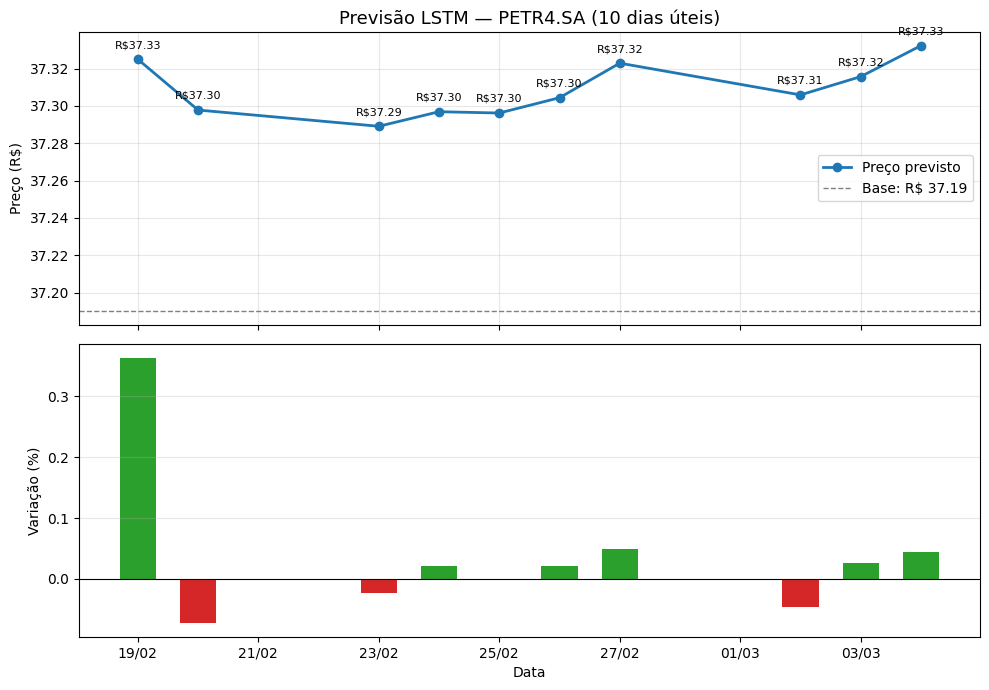

In [31]:
# Plot forecast prices and daily change
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

# Price line
ax1 = axes[0]
ax1.plot(df_fc.index, df_fc["predicted_price"], marker="o", linewidth=2,
         color="#1f77b4", label="Preço previsto")
ax1.axhline(fc["base_price"], color="gray", linestyle="--", linewidth=1,
            label=f"Base: R$ {fc['base_price']:.2f}")
for x, y in zip(df_fc.index, df_fc["predicted_price"]):
    ax1.annotate(f"R${y:.2f}", (x, y), textcoords="offset points",
                 xytext=(0, 8), ha="center", fontsize=8)
ax1.set_title(f"Previsão LSTM — {fc['symbol']} ({FORECAST_DAYS} dias úteis)", fontsize=13)
ax1.set_ylabel("Preço (R$)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Daily change bar
ax2 = axes[1]
colors = ["#2ca02c" if v >= 0 else "#d62728" for v in df_fc["expected_change_pct"]]
ax2.bar(df_fc.index, df_fc["expected_change_pct"], color=colors, width=0.6)
ax2.axhline(0, color="black", linewidth=0.8)
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))
ax2.set_ylabel("Variação (%)")
ax2.set_xlabel("Data")
ax2.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

### 4.1 Edge case — days out of valid range (expect 422)

In [32]:
# Max is 30 days
response_oob = requests.post(f"{BASE_URL}/predict/forecast", json={"symbol": SYMBOL, "days": 31})
print(f"Status: {response_oob.status_code}  (expected 422)")
print(json.dumps(response_oob.json(), indent=2, ensure_ascii=False))

Status: 422  (expected 422)
{
  "detail": [
    {
      "type": "less_than_equal",
      "loc": [
        "body",
        "days"
      ],
      "msg": "Input should be less than or equal to 30",
      "input": 31,
      "ctx": {
        "le": 30
      }
    }
  ]
}


---
## 5. GET `/monitoring/stats` — System metrics

In [33]:
response_stats = requests.get(f"{BASE_URL}/monitoring/stats")
pretty(response_stats)

Status: 200
{
  "timestamp": "2026-02-19T04:44:10.015545Z",
  "system": {
    "cpu_usage_percent": 0.7,
    "memory_used_mb": 719.93,
    "memory_available_mb": 5719.47,
    "pid": 1
  },
  "model": {
    "loaded": true,
    "load_time_ms": 76.54
  },
  "monitoring_endpoints": {
    "prometheus_metrics": "/metrics",
    "model_info": "/monitoring/model/info"
  }
}


In [34]:
stats    = response_stats.json()
sys_info = stats["system"]

print(f"CPU usage    : {sys_info['cpu_usage_percent']:.1f}%")
print(f"Memory used  : {sys_info['memory_used_mb']:.1f} MB")
print(f"Memory free  : {sys_info['memory_available_mb']:.1f} MB")
print(f"PID          : {sys_info['pid']}")
print(f"Model loaded : {stats['model']['loaded']}")
print(f"Load time    : {stats['model']['load_time_ms']:.2f} ms")

CPU usage    : 0.7%
Memory used  : 719.9 MB
Memory free  : 5719.5 MB
PID          : 1
Model loaded : True
Load time    : 76.54 ms


---
## 6. GET `/monitoring/model/info` — Model metadata

In [35]:
response_info = requests.get(f"{BASE_URL}/monitoring/model/info")
pretty(response_info)

Status: 200
{
  "symbol": "PETR4.SA",
  "architecture": "LSTM(128) -> LSTM(64) -> Dense(32) -> Dense(1)",
  "look_back_days": 60,
  "normalization": "per-window (divide by first element of window)",
  "target_description": "Close[t] / Close[t - look_back]  (ratio ~ 1.0)",
  "reconstruction": "pred_price = y_pred * ref  where ref = Close[t - look_back]",
  "training_period": "2018-01-01 → 2024-07-20",
  "data_splits": {
    "train": "70%",
    "validation": "15%",
    "test": "15%"
  },
  "hyperparameters": {
    "optimizer": "Adam (lr=1e-3, clipnorm=1.0)",
    "loss_function": "Huber",
    "batch_size": 32,
    "epochs_total": 150,
    "epochs_trained": 150
  },
  "metrics_test": {
    "MAE": 0.500759,
    "RMSE": 0.708671,
    "MAPE": 1.831505,
    "R2": 0.935971
  },
  "created_at": "2026-02-18T16:30:20.221686",
  "tf_version": "2.20.0",
  "model_load_time_ms": 76.54
}


In [36]:
info    = response_info.json()
metrics = info.get("metrics_test", {})
hparams = info.get("hyperparameters", {})

print("=== Model info ===")
print(f"  Symbol        : {info['symbol']}")
print(f"  Architecture  : {info['architecture']}")
print(f"  Look-back     : {info['look_back_days']} days")
print(f"  Normalization : {info['normalization']}")
print(f"  Training      : {info['training_period']}")
print(f"  TF version    : {info['tf_version']}")
print()
print("=== Hyperparameters ===")
for k, v in hparams.items():
    print(f"  {k:<20}: {v}")
print()
print("=== Test Metrics ===")
for k, v in metrics.items():
    print(f"  {k:<20}: {v}")

=== Model info ===
  Symbol        : PETR4.SA
  Architecture  : LSTM(128) -> LSTM(64) -> Dense(32) -> Dense(1)
  Look-back     : 60 days
  Normalization : per-window (divide by first element of window)
  Training      : 2018-01-01 → 2024-07-20
  TF version    : 2.20.0

=== Hyperparameters ===
  optimizer           : Adam (lr=1e-3, clipnorm=1.0)
  loss_function       : Huber
  batch_size          : 32
  epochs_total        : 150
  epochs_trained      : 150

=== Test Metrics ===
  MAE                 : 0.500759
  RMSE                : 0.708671
  MAPE                : 1.831505
  R2                  : 0.935971


---
## 7. GET `/metrics` — Prometheus metrics

In [37]:
response_prom = requests.get(f"{BASE_URL}/metrics")
print(f"Status       : {response_prom.status_code}")
print(f"Content-Type : {response_prom.headers.get('content-type', 'n/a')}")
print()
lines = response_prom.text.splitlines()
for line in lines[:50]:
    print(line)
if len(lines) > 50:
    print(f"... (+{len(lines) - 50} more lines)")

Status       : 200
Content-Type : text/plain; version=1.0.0; charset=utf-8

# HELP python_gc_objects_collected_total Objects collected during gc
# TYPE python_gc_objects_collected_total counter
python_gc_objects_collected_total{generation="0"} 4007.0
python_gc_objects_collected_total{generation="1"} 7592.0
python_gc_objects_collected_total{generation="2"} 490.0
# HELP python_gc_objects_uncollectable_total Uncollectable objects found during GC
# TYPE python_gc_objects_uncollectable_total counter
python_gc_objects_uncollectable_total{generation="0"} 0.0
python_gc_objects_uncollectable_total{generation="1"} 0.0
python_gc_objects_uncollectable_total{generation="2"} 0.0
# HELP python_gc_collections_total Number of times this generation was collected
# TYPE python_gc_collections_total counter
python_gc_collections_total{generation="0"} 985.0
python_gc_collections_total{generation="1"} 89.0
python_gc_collections_total{generation="2"} 7.0
# HELP python_info Python platform information
# TYPE p

In [38]:
# Filter custom application metrics only
custom_prefixes = ("prediction_", "http_")
custom_lines = [l for l in lines if any(l.startswith(p) for p in custom_prefixes)]

print("=== Custom Prometheus metrics ===")
for line in custom_lines:
    print(line)

=== Custom Prometheus metrics ===
http_requests_total{endpoint="/health",method="GET",status_code="200"} 73.0
http_requests_total{endpoint="/metrics",method="GET",status_code="200"} 211.0
http_requests_total{endpoint="/",method="GET",status_code="200"} 4.0
http_requests_total{endpoint="/predict",method="POST",status_code="200"} 3.0
http_requests_total{endpoint="/predict",method="POST",status_code="422"} 2.0
http_requests_total{endpoint="/predict/live",method="POST",status_code="200"} 3.0
http_requests_total{endpoint="/predict/live",method="POST",status_code="400"} 2.0
http_requests_total{endpoint="/predict/forecast",method="POST",status_code="200"} 3.0
http_requests_total{endpoint="/predict/forecast",method="POST",status_code="422"} 2.0
http_requests_total{endpoint="/monitoring/stats",method="GET",status_code="200"} 3.0
http_requests_total{endpoint="/monitoring/model/info",method="GET",status_code="200"} 3.0
http_requests_total{endpoint="/favicon.ico",method="GET",status_code="404"} 1.

---
## 8. Summary — All endpoints status

In [39]:
test_cases = [
    ("GET",  "/",                          lambda: requests.get(f"{BASE_URL}/")),
    ("GET",  "/health",                     lambda: requests.get(f"{BASE_URL}/health")),
    ("POST", "/predict (manual)",           lambda: requests.post(f"{BASE_URL}/predict",          json={"symbol": SYMBOL, "prices": prices_manual})),
    ("POST", "/predict/live",               lambda: requests.post(f"{BASE_URL}/predict/live",     json={"symbol": SYMBOL})),
    ("POST", "/predict/forecast (5 days)",  lambda: requests.post(f"{BASE_URL}/predict/forecast", json={"symbol": SYMBOL, "days": 5})),
    ("GET",  "/monitoring/stats",           lambda: requests.get(f"{BASE_URL}/monitoring/stats")),
    ("GET",  "/monitoring/model/info",      lambda: requests.get(f"{BASE_URL}/monitoring/model/info")),
    ("GET",  "/metrics",                    lambda: requests.get(f"{BASE_URL}/metrics")),
]

rows = []
for method, route, fn in test_cases:
    try:
        r = fn()
        ok = r.status_code < 400
        rows.append({"Method": method, "Route": route, "Status": r.status_code, "Result": "PASS" if ok else "FAIL"})
    except Exception as e:
        rows.append({"Method": method, "Route": route, "Status": "ERROR", "Result": "FAIL"})

df_summary = pd.DataFrame(rows)
df_summary.index = df_summary.index + 1
print(df_summary.to_string())

passed = (df_summary["Result"] == "PASS").sum()
total  = len(df_summary)
print(f"\n{'=' * 40}")
print(f"Result: {passed}/{total} endpoints passed")

  Method                       Route  Status Result
1    GET                           /     200   PASS
2    GET                     /health     200   PASS
3   POST           /predict (manual)     200   PASS
4   POST               /predict/live     200   PASS
5   POST  /predict/forecast (5 days)     200   PASS
6    GET           /monitoring/stats     200   PASS
7    GET      /monitoring/model/info     200   PASS
8    GET                    /metrics     200   PASS

Result: 8/8 endpoints passed
